### 1. Adatok beolvasása, előformázása, mergelése

In [1]:
import pandas as pd
app_df = pd.read_csv('data/application_record.csv')
cred_df = pd.read_csv('data/credit_record.csv')

cred_df.head(10)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


- `app_df`: application_record.csv fájl beolvasva. A pd.read_csv() feldolgozza a fájl tartalmát és egy táblázatos szerkezetű objektumot hoz létre amit DataFrame-nek nevezünk.
- `credit_df`: a credit_record.csv fájlt olvassa be és ugyanúgy DataFrame-t hoz létre belőle.

A `credit_record.csv` tartalmazza azokat az ID-hoz tartozó adatokat ami alapján egy ID-t (vagyis a mögötte álló ügyfelet) **"good client"** vagy **"bad client"** besorolással illetünk. Viszont jelenlegi formájában még nem megfelelő az adatok felépítése ahhoz, hogy összemergelhessük az `app_df` DataFrame-el, mivel a `credit_df` havi bontásban szerepelteti az ID-kat, és az aktuális havi credit státuszukat, vagyis minden ID több soron szerepel.

Ennek megfelelően a `credit_df` DataFrame-ből létre kell hozni egy új aggregált DataFrame-et, ami már minden ID-t aggregáltan (egyetlen soron tárol) és egy `is_bad` oszlopot, ami osztályozza az adott ID-hoz tartozó ügyfelet. Ezt a DataFrame-t fogjuk utána összemergelni az `app_df` DataFrame-el.

Ebben a példában egy szigorú bankot feltételezünk, ami minden olyan ügyfelet akinek volt már legalább 1 db 60 napnál később rendezett tartozása vagy legalább 3 db 30 napnál később rendezett tartozása az `bad client`-nek minősül.



In [2]:
def is_client_bad(series):
    late_statuses = ['1', '2', '3', '4', '5']
    very_late_statuses = ['2', '3', '4', '5']

    ever_very_late = any(s in very_late_statuses for s in series)

    freq_late_count = sum(s in late_statuses for s in series)
    is_frequent_offender = freq_late_count >= 3

    return 1 if (ever_very_late or is_frequent_offender) else 0

agg_df = cred_df.groupby('ID').agg(
    is_bad=('STATUS', is_client_bad)
).reset_index()

agg_df.head(10)

,ID,is_bad
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0
5,5001717,0
6,5001718,0
7,5001719,0
8,5001720,1
9,5001723,0


- `is_client_bad`: a függvény ami eldönti, hogy az adott ügyfél is_bad oszlopában 1-es (bad) vagy 0-s (good) szerepeljen
- `late_statuses`: azok a késési kategóriák, amelyek beleszámítanak a max 3 db késésbe
- `very_late_statuses`: azok a késési kategóriák, amelyekből 1 db is elég a "bad client" besoroláshoz
- `return 1 if (ever_very_late or is_frequent_offender) else 0`: Ha bármelyik a kettőből igaz, akkor `is_bad = 1` vagyis az ügyfél "bad client"
- `.reset_index()`: a groupby az ID-t állítja be index-nek, a `reset_index()` visszaállítja az ID-t rendes oszlopnak, ami megkönnyíti a mergelést



In [3]:
df = pd.merge(app_df, agg_df, on='ID', how='inner')
df.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,is_bad
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,0


- `df = pd.merge()`: Ez a függvény mergeli össze a paraméterekként megadott két DataFrame-et (app_df, agg_df)
- `on='ID'`: Ez a paraméter határozza meg hogy melyik oszlop alapján vonható össze a két DataFrame (hasonlóan SQL JOIN-nál)
- `how='inner'`: Ez a paraméter szintén hasonló az SQL-es INNER JOIN-hoz, azokat a sorokat tartjuk meg amelyekhez mindkét DataFrame-ben volt adat. Erre amiatt van szükség, mert bár az app_df 438.557 sort tartalmaz, credit státusza csak 36.457 ügyfélnek volt. A modellünk tanításához pedig kizárólag azokat recordokat tudjuk használni amelyhez, tartozik credit státusz.
- `df.head(10)`: Láthatjuk is az összesített DataFrame első 10 sorát. Ezek lesznek a kiindulási adataink, a predikciós modellek tanítása előtt azonban szükség van az adatok elemzésére, tisztítására a torzítások elkerülése és a legjobb eredmények elérése érdekében.

In [4]:
print("Bad clients: ", df['is_bad'].value_counts())

Bad clients:  is_bad
0    35073
1     1384
Name: count, dtype: int64


---

## **2. Adatok feltáró elemzése - Exploratory Data Analysis (EDA)**

Mielőtt belekezdenénk a modellépítésbe, fontos hogy megismerjük az adatokat. Ez a folyamat a feltáró adatelemzés (EDA), aminek célja, hogy jobban megértsük az adatainkat, felfedezzük a bennük rejlő mintákat és azonosítsuk a lehetéges problémákat (pl. hiányzó értékek, hibás bejegyzések).

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  str    
 2   FLAG_OWN_CAR         36457 non-null  str    
 3   FLAG_OWN_REALTY      36457 non-null  str    
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  str    
 7   NAME_EDUCATION_TYPE  36457 non-null  str    
 8   NAME_FAMILY_STATUS   36457 non-null  str    
 9   NAME_HOUSING_TYPE    36457 non-null  str    
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null  int64  
 1

`df.info()`: alapvető összefoglalót ad a DataFrame-ről. Láthatjuk, hogy hány oszlopból áll a DataFrame, a nem hiányzó értékek számát és az adatok típusát is.

Látható, hogy az `OCCUPATION_TYPE` jelentősen kevesebb, csupán 25134 sort tartalmaz szemben a 36457 sorral a többi oszlop esetében. Ezt az adattisztítás és előkészítés során mindenképpen kezelni kell majd.

In [6]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,is_bad
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,0.037963
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,0.191108
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000


A `describe()` metódus a DataFrame-ek numerikus oszlopainak statisztikai összefoglalóját adja meg. Gyors áttekintést nyújt az adatok eloszlásáról, ami segít azonosítani a lehetséges anomáliákat. A kimenet egy táblázat, ami az alábbi sorokat tartalmazza az egyes oszlopokra:
- `count`: a nem hiányzó értékek száma
- `mean`: az átlag
- `std`: a szórás
- `min`: a minimális érték
- `max`: a maximális érték
- `25%, 50%, 75%`: a kvartilisek (ezek a 25., 50. és 75. percentilisek, amelyek segítenek megérteni az adatok eloszlását)

Látható például a DAYS_BIRTH és DAYS_EMPLOYED nagy negatív számokat tartalmaznak. Ennek oka az életkor és foglalkoztatási idő sajátos tárolási logikája. A hivatalos adatbázis magyarázó szerint a DAYS_BIRTH a mai naptól visszafelé számolva jeleníti meg hány napos az adott ügyfél (ma = 0, tegnap = -1). Míg a DAYS_EMPLOYED szintén a mai naptól visszafelé számolja a foglalkoztatási időt, míg ha pozitív a szám azt jelenti az ügyfél jelenleg munkanélküli. Ez a modellépítés szempontjából mindenképpen problémás és az `OCCUPATION_TYPE`-hoz hasonlóan szintén kezelni szükséges.


In [7]:
print("Gender: ", df['CODE_GENDER'].value_counts(), '\n')
print("Occupation: ", df['OCCUPATION_TYPE'].value_counts(), '\n')
print("Owns a car: ", df['FLAG_OWN_CAR'].value_counts(), '\n')
print("Owns a property: ", df['FLAG_OWN_REALTY'].value_counts(), '\n')
print("Children count: ", df['CNT_CHILDREN'].value_counts(), '\n')
print("Income type: ", df['NAME_INCOME_TYPE'].value_counts(), '\n')
print("Education type: ", df['NAME_EDUCATION_TYPE'].value_counts(), '\n')
print("Family status: ", df['NAME_FAMILY_STATUS'].value_counts(), '\n')
print("Housing type: ", df['NAME_HOUSING_TYPE'].value_counts(), '\n')
print("Has a mobile: ", df['FLAG_MOBIL'].value_counts(), '\n')
print("Has a work phone: ", df['FLAG_WORK_PHONE'].value_counts(), '\n')
print("Has a phone: ", df['FLAG_PHONE'].value_counts(), '\n')
print("Has email: ", df['FLAG_EMAIL'].value_counts(), '\n')
print("Family size: ", df['CNT_FAM_MEMBERS'].value_counts(), '\n')

Gender:  CODE_GENDER
F    24430
M    12027
Name: count, dtype: int64 

Occupation:  OCCUPATION_TYPE
Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: count, dtype: int64 

Owns a car:  FLAG_OWN_CAR
N    22614
Y    13843
Name: count, dtype: int64 

Owns a property:  FLAG_OWN_REALTY
Y    24506
N    11951
Name: count, dtype: int64 

Children count:  CNT_CHILDREN
0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: count, dtype: int64 

Income

---

## **3. Adatok tisztítása (Data Cleaning) és előkészítése (Preprocessing)**

Az adatok feltáró elemzése során több is anomáliát azonosítottunk, amelyeket mindenképpen kezelni szükséges a modellépítés elkezdése előtt, annak érdekében, hogy a modellünk működése és előrejelzése is minél pontosabb lehessen. Az elemzés során azonosított problémák:
- `DAYS_EMPLOYED` negatív értékek és pozitív flag értékek kezelése
- `DAYS_BIRTH` nagyméretű negatív értékek kezelése
- `OCCUPATION_TYPE` jelentős számú NULL érték kezelése
- A `CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY` bár bináris értékeket tartalmaznak (M/F és Y/N) a modellek általában numerikus adatokkal dolgoznak így ezeket 1/0 értékekké érdemes alakítani

### **3.1 Azonosított anomáliák kezelése/tisztítása**

1. **DAYS_EMPLOYED anomáliák kezelése:**
- negatív értékek -> munkában töltött napok száma
- ha az ügyfél munkanélküli -> 365243 szerepel -> modell azt hiheti 1000 éves munkatapasztalata van -> torzítja a modell-t
- Megoldás:
    - Létre kell hozni egy `is_unemployed` oszlopot 0 és 1 értékkel,
    - A negatív értékeket pedig átszámoljuk évre, hogy a számok ne mozogjanak több ezres nagyságrendekben, skálákon (pl gyerek szám max 19, days_employed -15713, modell számára torzító hatású lehet a súlyozásnál a nagyságrendbeli különbség a két változó értékei között)

2. **DAYS_BIRTH kezelése:**
Ebben az esetben is hasonló nagyságrendbeli probléma van, a torzítás elkerülése érdekében ezeket a számokat is évre alakítjuk át.

Először ellenőrizzük, hogy a `DAY_EMPLOYED` valóban nem tartalmaz pozitív számokat a flag-ként működő 365234 értéken kívül:

In [8]:
strange_positives = df[(df['DAYS_EMPLOYED'] > 0) & (df['DAYS_EMPLOYED'] != 365243)]

print(f"Number of anomalies: {len(strange_positives)}")
if not strange_positives.empty:
    print(strange_positives['DAYS_EMPLOYED'].unique())

Number of anomalies: 0


In [9]:
#1. Handle the DAYS_EMPLOYED anomaly
df['is_unemployed'] = (df['DAYS_EMPLOYED'] > 0).astype(int)
df['years_employed'] = ((df['DAYS_EMPLOYED'].clip(upper=0) * -1) / 365).round(1)

#2. Handle DAYS_BIRTH
df['age'] = (df['DAYS_BIRTH'] / -365).astype(int)
df = df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'])

print(df['is_unemployed'].value_counts())
print(df['years_employed'].value_counts())

is_unemployed
0    30322
1     6135
Name: count, dtype: int64
years_employed
0.0     6138
0.8      418
1.8      403
0.3      392
4.6      382
        ... 
24.5       1
43.0       1
36.9       1
0.1        1
30.9       1
Name: count, Length: 350, dtype: int64


- `df['is_unemployed'] = (df['DAYS_EMPLOYED'] > 0).astype(int)`: logikai műveletet hajt végre ahol a `DAYS_EMPLOYED` értéke pozitív ott True-t ad vissza, egyébként False-t. Ezt a integerré alakítva 1-et és 0-t kapunk.
- `df['years_employed']`: A foglalkoztatásban töltött napok számát megszorozzuk -1-el és leosztjuk 365-el, így megkapjuk az évek számát, amit 1 tiezedesre kerekítünk.
- `.clip(upper= 0)`: Ez a pandas metódus lehetővé teszi határértékek megszabását, így az ennél nagyobb értékek automatikusan a határértékre lesznek kicserélve, mivel a munkanélküliek 365234-el vannak jelölve az `upper=0` automatikusan 0-ra állítja a napok számát, így a munkanélküliek is megfelelően kezelve lettek.
- `df['age'] = (df['DAYS_BIRTH'] / -365).astype(int)`: A `DAYS_EMPLOYED`-hoz hasonlóan a `DAYS_BIRTH`-t is átszámoljuk évre, egy új `age` oszlopban.
- `df.drop(column=['DAYS_BIRTH', 'DAYS_EMPLOYED'])`: Az adatok átalakítása és átszámolása után a feleslegesség vált oszlopokat töröljük a DataFrame-ből.

<Axes: xlabel='age', ylabel='Count'>

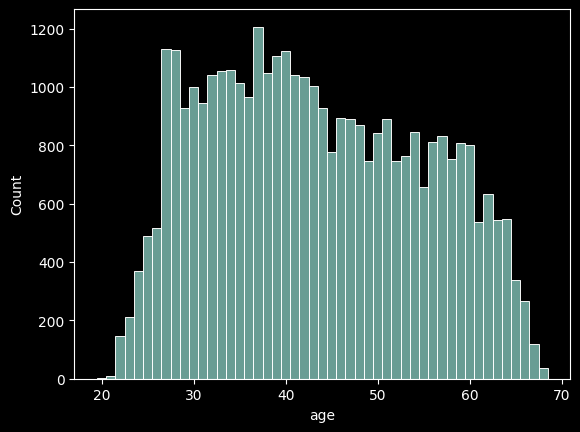

In [10]:
import seaborn as sns
sns.histplot(data=df, x='age', discrete=True)

3. **OCCUPATION_TYPE kezelése:**
    Az adatok feltáró elemzése során szembetűnő volt, hogy az `OCCUPATION_TYPE` oszlopnál több, mint 10 000-el kevesebb sor szerepel, mint a többi oszlop esetében. Ennek oka valószínűleg az, hogy ez a mezőt nem volt kötelező kitölteni az ügyfeleknek, így az ügyfelek egy jelentős része nem adta meg a foglalkozását. Ilyen kategorizálási esetben a legjobb megközelítés, az érintett sorok törlése helyett (ami az adataink közel 1/3-át érintené!) egy új "Unknown" kategória bevezetése és minden üres sor besorolása ebbe a kategóriába. Ezáltal a modellünk képes lesz a tanulása során akár összefüggést is felfedezni aközött, hogy esetleg a mező üresen hagyása korrelál-e azzal, hogy egy ügyfél végül "bad client" besorolást kap.

In [11]:
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')

print("Occupation types: ", df['OCCUPATION_TYPE'].value_counts())

Occupation types:  OCCUPATION_TYPE
Unknown                  11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  3012
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Security staff             592
Cleaning staff             551
Private service staff      344
Low-skill Laborers         175
Waiters/barmen staff       174
Secretaries                151
HR staff                    85
Realty agents               79
IT staff                    60
Name: count, dtype: int64


4. **Szöveges bináris értékek kezelése:**
A `FLAG_OWN_CAR`, `FLAG_OWN_REALTY` bár bináris értékeket tartalmaznak (Y/N) a modellek általában numerikus adatokkal dolgoznak így ezeket 1/0 értékekké érdemes alakítani. A `CODE_GENDER` értékeket pedig M/F-ről 1/2-re módosítjuk.

In [12]:
df['CODE_GENDER'] = df['CODE_GENDER'].replace({'M': 1, 'F': 2})
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})
df.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,is_bad,is_unemployed,years_employed,age
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,0,0,12.4,32
1,5008805,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,0,0,12.4,32
2,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,0,3.1,58
3,5008808,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,0,8.4,52
4,5008809,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,0,8.4,52
5,5008810,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,0,8.4,52
6,5008811,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,0,8.4,52
7,5008812,2,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unknown,1.0,0,1,0.0,61
8,5008813,2,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unknown,1.0,0,1,0.0,61
9,5008814,2,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unknown,1.0,0,1,0.0,61




### **3.2 Adatok szétválasztása**

Az adatelemzés egyik alapelve, hogy a modellünket ne azokon az adatokon teszteljük, amelyeken tanítottuk. Annak érdekében hogy az adatok transzformálása során se történjen semmilyen adatszivárgás, a gépi tanulási modellek építése során az a legjobb gyakorlat, ha az adattisztítás után, az adatok transzformálását már a split után hajtuk végre ezzel megelőzve, hogy a modellünk olyan többletinformációkhoz juthasson a teljes sokaságra vonatkozóan amelyek torzíthatják a működését a későbbiekben.

1. **Függő és független változók szétválasztása**
    - Függő változó: A megjósolandó változó, amit a modellünknek előre kell tudni jeleznie (`is_bad` oszlop)
    - Független változók: Az előrejelzéshez használt

In [13]:
# Független változók
X = df.drop(['is_bad'], axis=1)

# Függő változók
y = df['is_bad']

X.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,is_unemployed,years_employed,age
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,0,12.4,32
1,5008805,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,0,12.4,32
2,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,3.1,58
3,5008808,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,8.4,52
4,5008809,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,8.4,52
5,5008810,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,8.4,52
6,5008811,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,8.4,52
7,5008812,2,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unknown,1.0,1,0.0,61
8,5008813,2,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unknown,1.0,1,0.0,61
9,5008814,2,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unknown,1.0,1,0.0,61


In [14]:
y.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: is_bad, dtype: int64

2. **Learning data - Test data split**
    - **Tanító adatok (Training data)**: ezen az adatkészleten fogjuk a modellt felépíteni és tanítani.
    - **Teszt adatok (Test data)**: ezen az adatkészleten fogjuk a tanult modellt validálni. Ezt a részt a modell nem látja a tanulási folyamat során, így valós képet kapunk a teljesítményéről.


A felosztás végrehajtásáhot a `scikit-learn` nevű, gépi könyvtárat használjuk.


In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,is_unemployed,years_employed,age
18780,5074676,1,0,1,0,247500.0,State servant,Secondary / secondary special,Married,House / apartment,1,0,0,0,Medicine staff,2.0,0,14.7,37
24681,5117553,1,1,0,1,148500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,1,1,0,Drivers,3.0,0,7.8,35
26570,5112831,2,0,1,1,90000.0,Commercial associate,Secondary / secondary special,Married,With parents,1,0,0,0,Sales staff,3.0,0,1.7,31
11051,5046331,2,0,1,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0,Unknown,2.0,1,0.0,56
29854,5118396,1,1,0,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,0,0,High skill tech staff,2.0,0,12.8,31
12641,5052859,2,0,1,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Sales staff,4.0,0,3.8,38
4479,5024493,1,0,1,1,135000.0,Working,Secondary / secondary special,Married,Rented apartment,1,1,1,0,Laborers,3.0,0,7.5,28
18332,5069001,1,1,1,0,225000.0,Working,Higher education,Married,House / apartment,1,0,0,0,Sales staff,2.0,0,1.0,50
23823,5096253,1,0,0,2,247500.0,Working,Secondary / secondary special,Married,Office apartment,1,1,1,0,Laborers,4.0,0,8.9,38
9398,5041640,2,0,1,0,225000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,1,0,1,0,Unknown,2.0,0,15.3,45


A fenti sor a train_test_split függvényt hívja meg, amely az adatokat a fent leírt módon felosztja. A kód a következő fő paramétereket használja:
- `X és y`: A bemeneti adatkészlet (a független változók X, és a függő változó y).
- `test_size=0.20`: Ez a paraméter határozza meg, hogy a teljes adathalmazunk hány százaléka kerüljön a tesztkészletbe. A 0.20 érték azt jelenti, hogy az adatok 20%-a lesz a tesztadat, a fennmaradó 80% pedig a tanító adat.
- `random_state=42`: Ez a paraméter biztosítja a reprodukálhatóságot. A függvény véletlenszerűen választja ki a sorokat, és a random_state paraméterrel garantáljuk, hogy minden futtatáskor ugyanazt a felosztást kapjuk. Ez akkor fontos, ha meg akarjuk ismételni a kísérleteinket, vagy szeretnénk azokat megosztani másokkal.
- `stratify=y`: Mivel a "bad" eseteket nagyjából 3%-ban vannak jelen a teljes mintában, a stratify=y biztosítja, hogy a mindkét set-ben (train, test) azonos %-ban legyenek jelen.

A kimeneti értékek a szétválasztott adatokat tartalmazó négy új DataFrame: a tanító adatok független (X_train) és függő (y_train) változói, valamint a teszt adatok független (X_test) és függő (y_test) változói.



### **3.3 Adatok transzformációja (Data Preprocessing)**

A legtöbb gépi tanulási modell nem tudja közvetlenül kezelni a nyers adatokat. A numerikus változók, mint például a income összege, és a kategorikus változók, mint például a családi állapot, teljesen eltérő skálán és formában vannak. A pontos és hatékony modellépítés érdekében ezeket az adatokat egységes formára kell hoznunk. Két fő transzformációt hajtunk végre:
- **Standardizálás (Standardization)**: ez a numerikus adatokra vonatkozik. A StandardScaler az átlagot nullára (0), a szórást pedig egyre (1) skálázza. Ez megakadályozza, hogy a nagyobb értékeket tartalmazó oszlopok (pl. az `AMT_INCOME_TOTAL`) nagyobb súllyal számítsanak a modellben, mint a kisebb értékűek (pl. az `AGE`).
- **Kategorikus kódolás (One-Hot Encoding)**: ezt a kategóriákra alkalmazzuk. A OneHotEncoder minden kategóriát egy új bináris oszloppá alakít és minden sorban az éppen aktuális kategóriához tartozó oszlopot 1-re, a többit 0-ra állítja. Ez lehetővé teszi a modell számára, hogy az egyes kategóriákat azonos súllyal kezelje. (Esetünkben érintett oszlopk: `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `NAME_FAMILY_STATUS`, `NAME_HOUSING_TYPE`, `OCCUPATION_TYPE`)

Annak érdekében, hogy az ID-k se zavarjanak bele a modell működésébe (pl. egy nagy ID-val rendelkező ügyfélhez ne rendeljen nagyobb megbízhatóságot a modell) az ID-kat külön változókba mentjük a sorok későbbi beazonosíthatóság érdekében, majd az X_train és X_test táblákból töröljük ezt az oszlopot.


In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Save IDs for later
train_IDs = X_train['ID']
test_IDs = X_test['ID']

# Drop ID from the actual feature set
X_train = X_train.drop(columns=['ID'])
X_test = X_test.drop(columns=['ID'])

# Group variables
categorical_features = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
numerical_features = ['AMT_INCOME_TOTAL', 'years_employed', 'age', 'CNT_CHILDREN', 'CNT_FAMILY_MEMBERS']

# Define the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # All the other columns will be unchanged
)

# Fit and transform on train data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_transformed = preprocessor.transform(X_test)


ValueError: A given column is not a column of the dataframe

- `ColumnTransformer(...)`: ez a függvény hozza létre az adatfeldolgozó objektumot.
    - A `transformers` paraméter egy lista, amely minden egyes transzformációhoz tartozó listát tartalmaz.
    - Minden listában megadjuk a transzformáció nevét ('num', 'cat'), a használt transzformátort (`StandardScaler()`, `OneHotEncoder()`), és az oszlopok listáját, amelyekre alkalmazni kell.
    - A `remainder='passthrough'` paraméterrel biztosítjuk, hogy a fentebb nem megadott oszlopokat a transformer változatlanul hagyja.
    - A `handle_unknown='ignore'` biztosítja, hogyha a test adatban a modell olyan kategóriával találkozik ami nem szerepelt a tanulási adatokban (pl. ritka pozíció) akkor nem dob hibát hanem minden érintett oszlopot kinulláz az adott sorban.
    - `sparse_output=False`: A OneHotEncoder default beállításként "sparse matrix"-ot készít, hogy kimélje a memóriát. Tehát csak azt jegyzi meg hol vannak 1-esek és a többi nullát "elfelejti", hogy helyeet spóroljon. A pandas azonban a szabványos "dense array" (sűrű tömböket) preferálja, ahol minden nulla is szerepel. A sparse_output false-ra állításával ezt biztosítjuk.

- `preprocessor.fit_transform(X_train)`: ez az átalakítás lépése. A fit_transform() metódusnak két feladata van:
    - `fit`: megtanulja az adatokból szükséges transzformációs paramétereket (pl. a numerikus oszlopok átlagát és szórását, vagy a kategóriák listáját). Fontos, hogy ezt a "tanulást" csak a tanítóhalmazon (X_train) végezzük el.
    - `transform`: alkalmazza a tanult paramétereket a X_train adatokra, és visszatér a transzformált eredményekkel.